# Data Exploration for Landcover Classification

This notebook explores both the LiDAR point cloud data and the multispectral orthophoto data used for landcover classification in the Wädenswil region.

**Contents:**
1. LiDAR Point Cloud Analysis
2. Multispectral Orthophoto Analysis
3. Class Distribution and Feature Correlations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import rasterio
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Define paths
DATA_DIR = Path(r'A:\STUDIUM\05_Herbstsemester25\PA2\data')
PROCESSED_DIR = DATA_DIR / 'processed' / 'pointnet_tiles'
TRAINING_DATA_DIR = DATA_DIR / 'aerial' / 'training_data'

## 1. LiDAR Point Cloud Data Analysis

### 1.1 Dataset Overview

In [6]:
# Load metadata
with open(PROCESSED_DIR / 'metadata.json', 'r') as f:
    metadata = json.load(f)

print("=" * 60)
print("LIDAR DATASET METADATA")
print("=" * 60)
print(f"Tile Size: {metadata['tile_size']}m × {metadata['tile_size']}m")
print(f"Points per Tile: {metadata['points_per_tile']:,}")
print(f"\nTotal Tiles: {metadata['num_train_tiles'] + metadata['num_val_tiles'] + metadata['num_test_tiles']:,}")
print(f"  - Training:   {metadata['num_train_tiles']:,}")
print(f"  - Validation: {metadata['num_val_tiles']:,}")
print(f"  - Test:       {metadata['num_test_tiles']:,}")
print(f"\nClasses: {metadata['num_classes']}")
for class_id, class_name in metadata['classes'].items():
    print(f"  {class_id}: {class_name}")
print(f"\nFeatures: {len(metadata['feature_names'])}")
for feature in metadata['feature_names']:
    print(f"  - {feature}")
print("=" * 60)

LIDAR DATASET METADATA
Tile Size: 25m × 25m
Points per Tile: 16,384

Total Tiles: 8,750
  - Training:   6,125
  - Validation: 1,312
  - Test:       1,313

Classes: 5
  0: Water
  1: Tree canopy
  2: Low vegetation
  3: Impervious
  4: Buildings

Features: 7
  - X
  - Y
  - Z
  - Intensity
  - ReturnNumber
  - NumberOfReturns
  - ScanAngle


### 1.2 Load Complete Dataset

In [7]:
# Load all data (combined train, val, test)
train_features = np.load(PROCESSED_DIR / 'train_features.npy')
val_features = np.load(PROCESSED_DIR / 'val_features.npy')
test_features = np.load(PROCESSED_DIR / 'test_features.npy')

train_labels = np.load(PROCESSED_DIR / 'train_labels.npy')
val_labels = np.load(PROCESSED_DIR / 'val_labels.npy')
test_labels = np.load(PROCESSED_DIR / 'test_labels.npy')

# Combine all data
all_features = np.concatenate([train_features, val_features, test_features], axis=0)
all_labels = np.concatenate([train_labels, val_labels, test_labels], axis=0)

print(f"Combined dataset shape: {all_features.shape}")
print(f"Total tiles: {all_features.shape[0]:,}")
print(f"Points per tile: {all_features.shape[1]:,}")
print(f"Features per point: {all_features.shape[2]}")
print(f"Total points: {all_labels.size:,}")

Combined dataset shape: (8750, 16384, 7)
Total tiles: 8,750
Points per tile: 16,384
Features per point: 7
Total points: 143,360,000


### 1.3 Class Distribution

In [8]:
# Calculate class distribution
unique, counts = np.unique(all_labels, return_counts=True)
total = all_labels.size

print("\nClass Distribution (Complete Dataset):")
print("-" * 70)
print(f"{'Class ID':<10} {'Class Name':<20} {'Points':<15} {'Percentage':<10}")
print("-" * 70)

for class_id, count in zip(unique, counts):
    class_name = metadata['classes'][str(int(class_id))]
    percentage = (count / total) * 100
    print(f"{int(class_id):<10} {class_name:<20} {count:<15,} {percentage:>6.2f}%")

print("-" * 70)
print(f"{'Total':<10} {'':<20} {total:<15,} {100.00:>6.2f}%")
print("-" * 70)

imbalance_ratio = np.max(counts) / np.min(counts)
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.1f}:1")


Class Distribution (Complete Dataset):
----------------------------------------------------------------------
Class ID   Class Name           Points          Percentage
----------------------------------------------------------------------
0          Water                1,026,350         0.72%
1          Tree canopy          22,947,034       16.01%
2          Low vegetation       84,169,330       58.71%
3          Impervious           18,942,888       13.21%
4          Buildings            16,274,398       11.35%
----------------------------------------------------------------------
Total                           143,360,000     100.00%
----------------------------------------------------------------------

Class Imbalance Ratio: 82.0:1


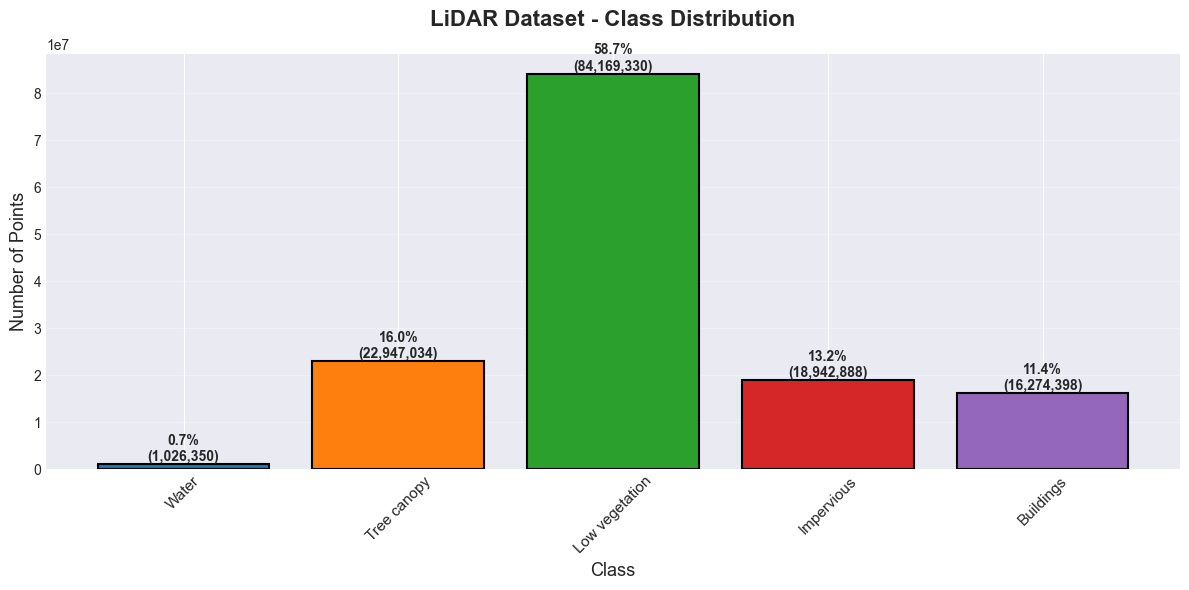

In [9]:
# Visualize class distribution
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
class_names = [metadata['classes'][str(int(i))] for i in unique]

bars = ax.bar(class_names, counts, color=colors, edgecolor='black', linewidth=1.5)
ax.set_title('LiDAR Dataset - Class Distribution', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Class', fontsize=13)
ax.set_ylabel('Number of Points', fontsize=13)
ax.tick_params(axis='x', rotation=45, labelsize=11)
ax.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    percentage = (count / total) * 100
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{percentage:.1f}%\n({count:,})',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### 1.4 Feature Distribution Analysis

In [10]:
# Sample tiles for feature analysis
n_sample_tiles = 200
sample_indices = np.random.choice(all_features.shape[0], n_sample_tiles, replace=False)
sample_features = all_features[sample_indices]
sample_labels = all_labels[sample_indices]

print(f"Sampled {n_sample_tiles} tiles for feature analysis")
print(f"Total sampled points: {sample_features.size // sample_features.shape[2]:,}")

Sampled 200 tiles for feature analysis
Total sampled points: 3,276,800


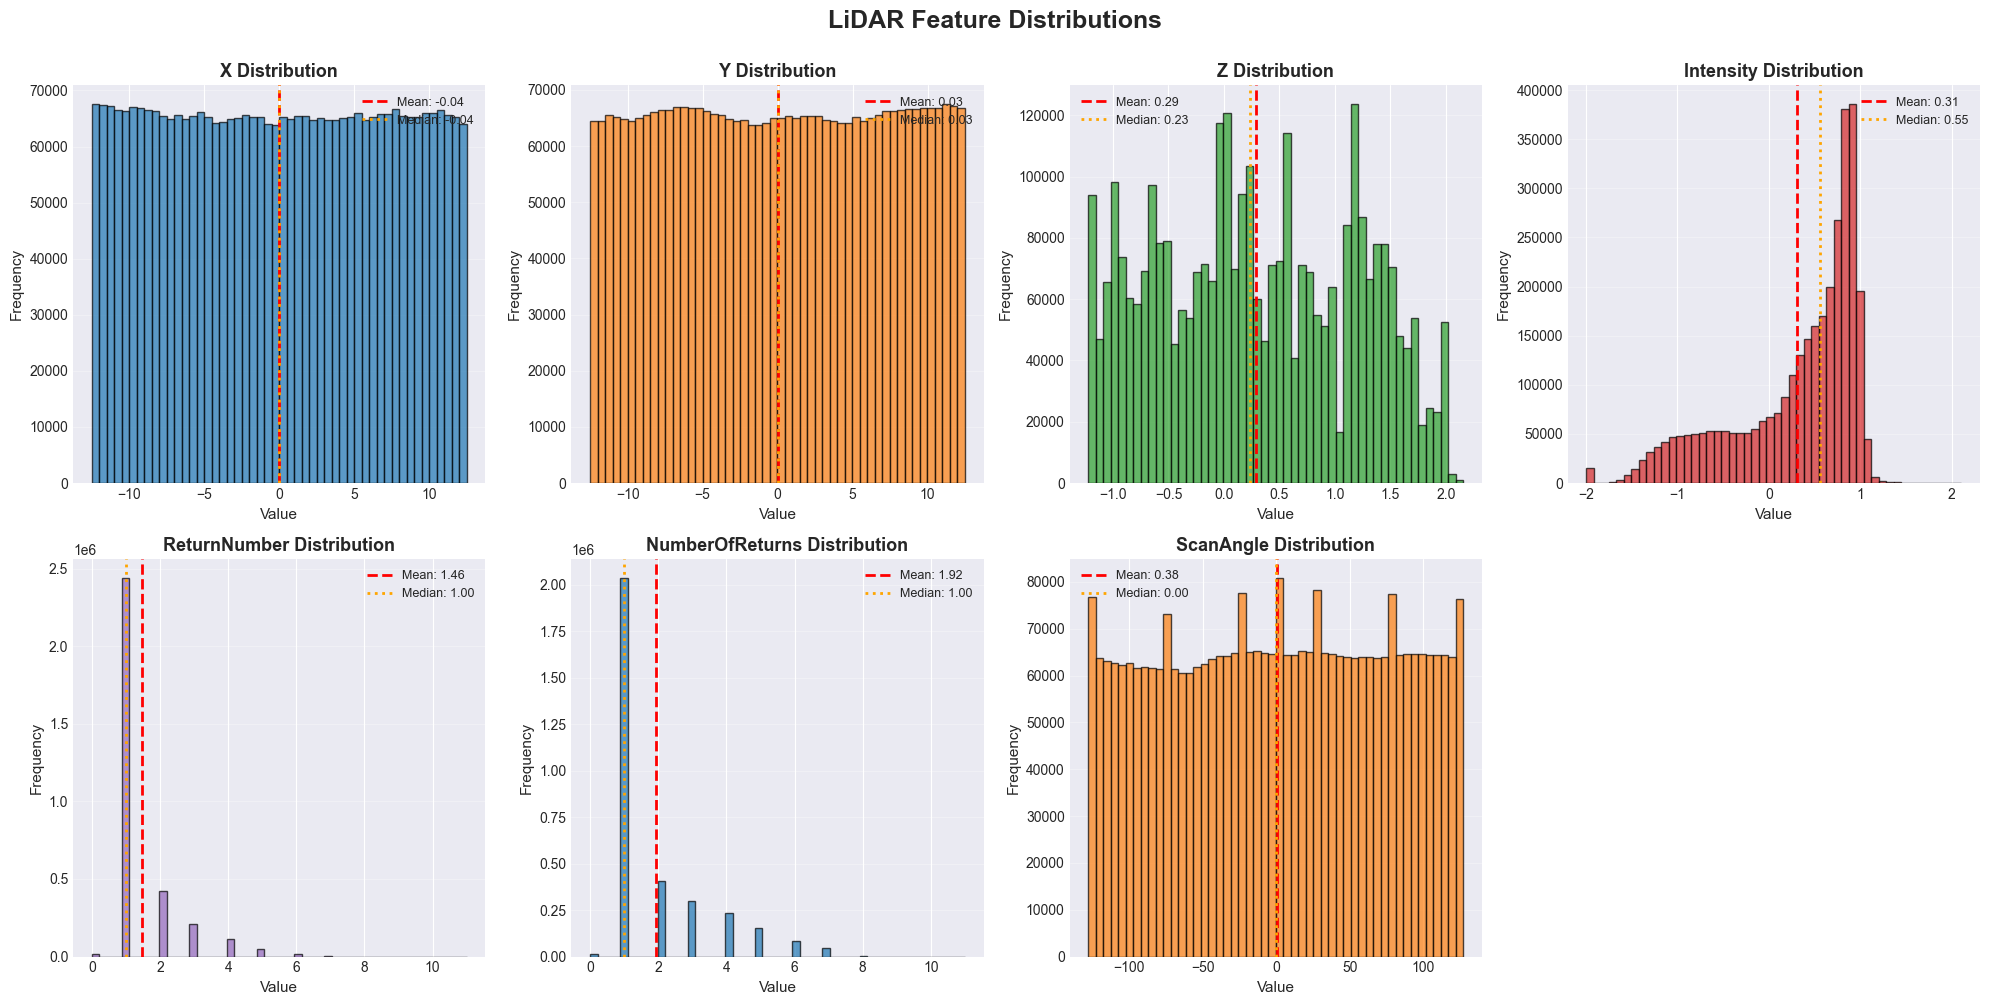

In [11]:
# Plot feature distributions
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

feature_names = metadata['feature_names']

for i, (feature_name, ax) in enumerate(zip(feature_names, axes)):
    feature_data = sample_features[:, :, i].flatten()
    
    ax.hist(feature_data, bins=50, color=colors[i % len(colors)], alpha=0.7, edgecolor='black')
    ax.set_title(f'{feature_name} Distribution', fontsize=13, fontweight='bold')
    ax.set_xlabel('Value', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    
    # Add statistics
    mean_val = np.mean(feature_data)
    median_val = np.median(feature_data)
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='orange', linestyle=':', linewidth=2, label=f'Median: {median_val:.2f}')
    ax.legend(fontsize=9)

fig.delaxes(axes[-1])

plt.suptitle('LiDAR Feature Distributions', fontsize=18, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [12]:
# Feature statistics table
print("\n" + "=" * 90)
print("FEATURE STATISTICS")
print("=" * 90)
print(f"{'Feature':<20} {'Mean':<12} {'Median':<12} {'Std':<12} {'Min':<12} {'Max':<12}")
print("-" * 90)

for i, feature_name in enumerate(feature_names):
    feature_data = sample_features[:, :, i].flatten()
    print(f"{feature_name:<20} {np.mean(feature_data):<12.4f} {np.median(feature_data):<12.4f} "
          f"{np.std(feature_data):<12.4f} {np.min(feature_data):<12.4f} {np.max(feature_data):<12.4f}")

print("=" * 90)


FEATURE STATISTICS
Feature              Mean         Median       Std          Min          Max         
------------------------------------------------------------------------------------------
X                    -0.0410      -0.0400      7.2425       -12.5000     12.4900     
Y                    0.0282       0.0300       7.2368       -12.5000     12.4900     
Z                    0.2924       0.2309       0.8826       -1.2225      2.1545      
Intensity            0.3051       0.5544       0.6828       -1.9924      2.1034      
ReturnNumber         1.4568       1.0000       0.9737       0.0000       11.0000     
NumberOfReturns      1.9218       1.0000       1.4941       0.0000       11.0000     
ScanAngle            0.3797       0.0000       73.5524      -128.0000    127.0000    
ReturnNumber         1.4568       1.0000       0.9737       0.0000       11.0000     
NumberOfReturns      1.9218       1.0000       1.4941       0.0000       11.0000     
ScanAngle            0.3797  

### 1.5 Feature Correlation Matrix


Feature Correlation Matrix:
                        X         Y         Z  Intensity  ReturnNumber  \
X                1.000000  0.001637  0.012965  -0.007071     -0.004389   
Y                0.001637  1.000000  0.014452  -0.015375      0.006294   
Z                0.012965  0.014452  1.000000   0.074690      0.026229   
Intensity       -0.007071 -0.015375  0.074690   1.000000     -0.419016   
ReturnNumber    -0.004389  0.006294  0.026229  -0.419016      1.000000   
NumberOfReturns -0.004242  0.008674  0.061498  -0.683048      0.755929   
ScanAngle       -0.003116  0.033427  0.004281   0.000906      0.000369   

                 NumberOfReturns  ScanAngle  
X                      -0.004242  -0.003116  
Y                       0.008674   0.033427  
Z                       0.061498   0.004281  
Intensity              -0.683048   0.000906  
ReturnNumber            0.755929   0.000369  
NumberOfReturns         1.000000   0.000076  
ScanAngle               0.000076   1.000000  


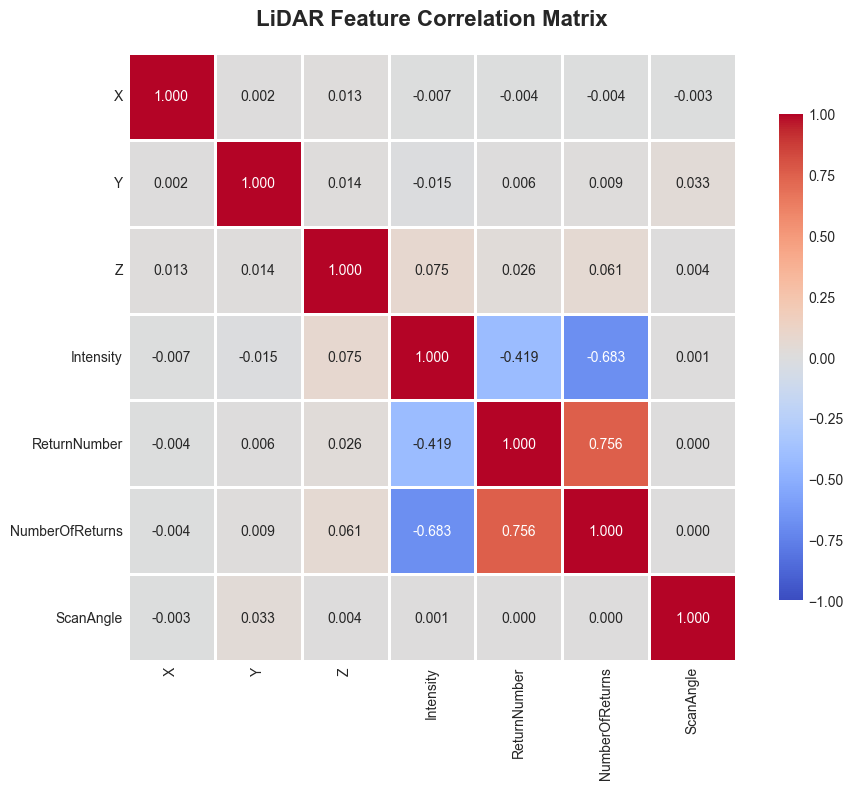

In [13]:
# Compute correlation matrix
# Reshape to (n_points, n_features)
features_2d = sample_features.reshape(-1, sample_features.shape[2])

# Create DataFrame for easier correlation calculation
df_features = pd.DataFrame(features_2d, columns=feature_names)
correlation_matrix = df_features.corr()

print("\nFeature Correlation Matrix:")
print(correlation_matrix)

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)

ax.set_title('LiDAR Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### 1.6 3D Visualization of Sample Tiles

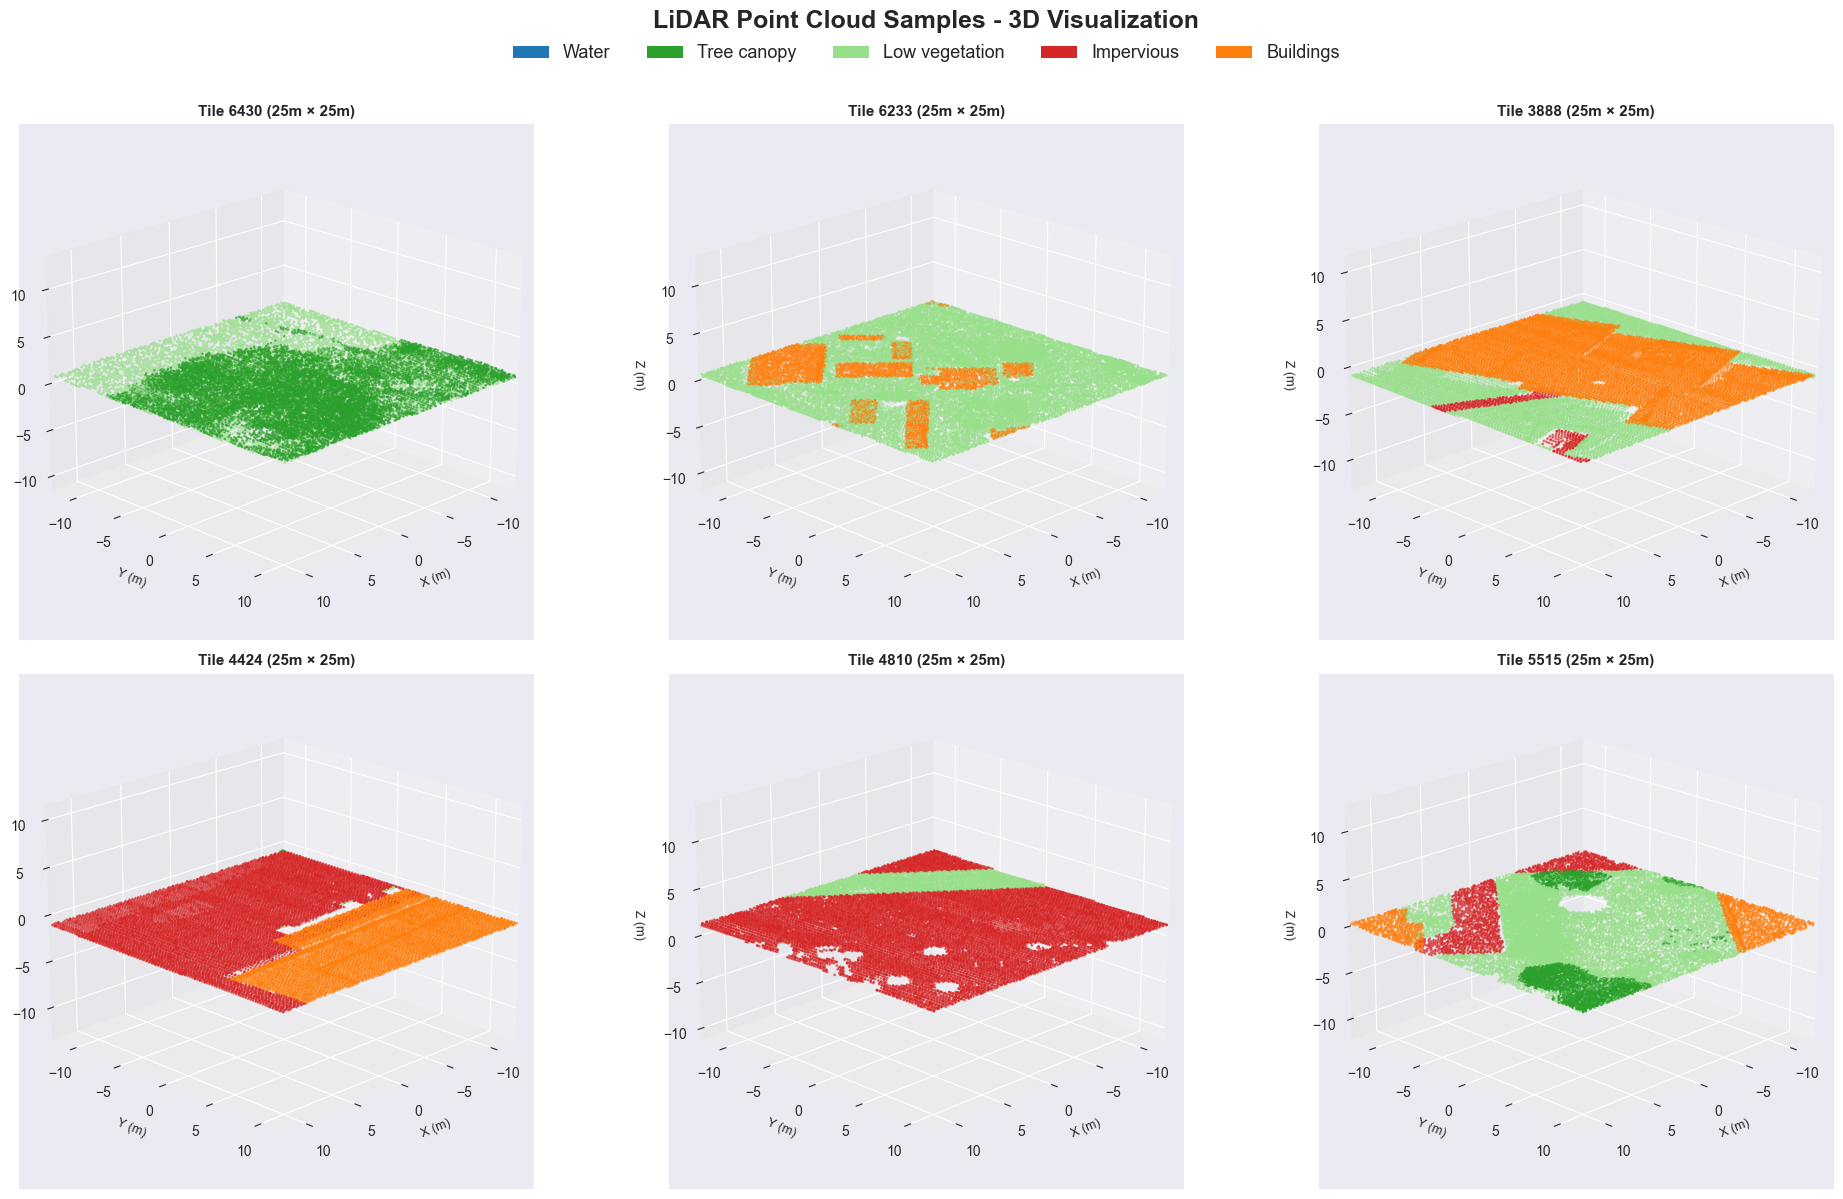

In [14]:
# Visualize 3D point clouds with class colors
fig = plt.figure(figsize=(20, 12))

n_vis_tiles = 6
vis_indices = np.random.choice(sample_indices, n_vis_tiles, replace=False)

class_colors = {
    0: '#1f77b4',  # Water - Blue
    1: '#2ca02c',  # Tree canopy - Green
    2: '#98df8a',  # Low vegetation - Light Green
    3: '#d62728',  # Impervious - Red
    4: '#ff7f0e'   # Buildings - Orange
}

for idx, tile_idx in enumerate(vis_indices):
    ax = fig.add_subplot(2, 3, idx + 1, projection='3d')
    
    tile_features = all_features[tile_idx]
    tile_labels = all_labels[tile_idx]
    
    x = tile_features[:, 0]
    y = tile_features[:, 1]
    z = tile_features[:, 2]
    
    point_colors = [class_colors[int(label)] for label in tile_labels]
    
    ax.scatter(x, y, z, c=point_colors, s=1, alpha=0.6)
    
    ax.set_xlabel('X (m)', fontsize=9)
    ax.set_ylabel('Y (m)', fontsize=9)
    ax.set_zlabel('Z (m)', fontsize=9)
    ax.set_title(f'Tile {tile_idx} (25m × 25m)', fontsize=11, fontweight='bold')
    ax.view_init(elev=20, azim=45)
    
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0
    mid_x = (x.max()+x.min()) * 0.5
    mid_y = (y.max()+y.min()) * 0.5
    mid_z = (z.max()+z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=class_colors[i], label=metadata['classes'][str(i)]) 
                   for i in range(5)]
fig.legend(handles=legend_elements, loc='upper center', ncol=5, fontsize=13, 
           bbox_to_anchor=(0.5, 0.98))

plt.suptitle('LiDAR Point Cloud Samples - 3D Visualization', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 2. Multispectral Orthophoto Analysis

### 2.1 Class Distribution in Orthophoto Labels

In [19]:
# Load label masks to analyze pixel distribution per class
mask_files = [f for f in TRAINING_DATA_DIR.glob('*_lable_mask.tif') if f.is_file()]
print(f"Found {len(mask_files)} label mask files")
for mask in mask_files:
    print(f"  - {mask.name}")

Found 4 label mask files
  - cliped_21_lable_mask.tif
  - cliped_22_lable_mask.tif
  - cliped_24_lable_mask.tif
  - cliped_25_lable_mask.tif


### 2.2 Pixel Count per Class


Orthophoto Class Distribution (Pixel-based):
----------------------------------------------------------------------
Class ID   Class Name           Pixels          Percentage
----------------------------------------------------------------------
0          Water                114,181,786      14.83%
1          Tree canopy          102,339,602      13.29%
2          Low vegetation       360,320,096      46.80%
3          Impervious           126,271,341      16.40%
4          Buildings            66,864,263        8.68%
----------------------------------------------------------------------
Total                           769,977,088     100.00%
----------------------------------------------------------------------

Class Imbalance Ratio: 5.4:1


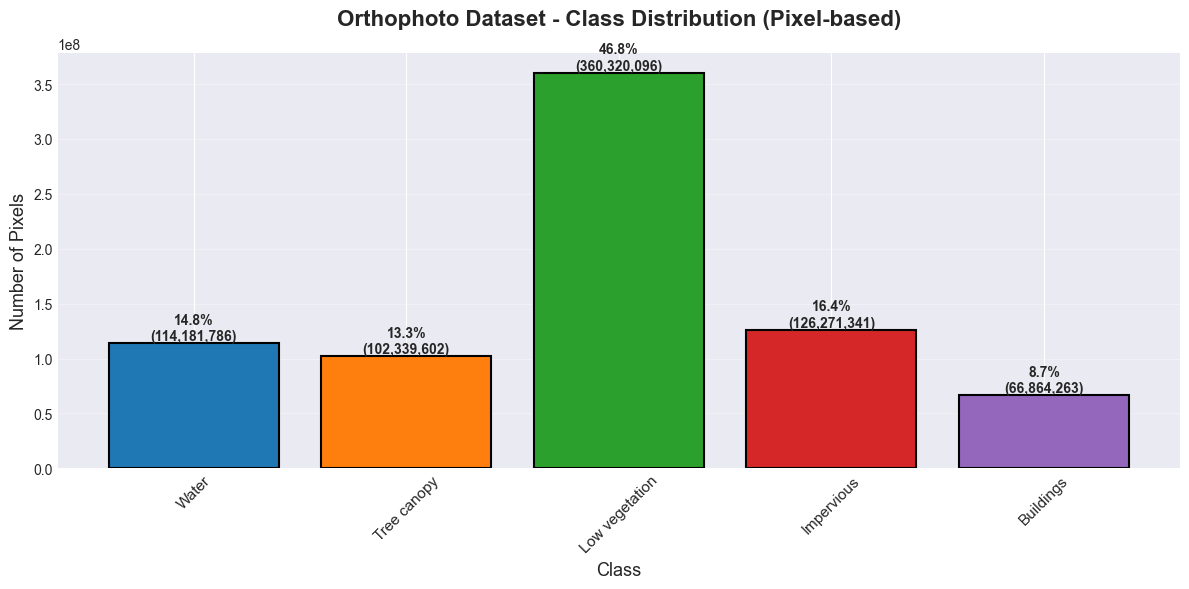

In [20]:
# Analyze pixel distribution across all orthophoto masks
if len(mask_files) > 0:
    # Aggregate pixel counts across all masks
    all_pixels = []
    
    for mask_file in mask_files:
        try:
            with rasterio.open(mask_file) as src:
                mask_data = src.read(1)  # Read single band (labels)
                all_pixels.append(mask_data.flatten())
        except Exception as e:
            print(f"Error loading {mask_file.name}: {e}")
    
    # Combine all pixels
    all_pixels = np.concatenate(all_pixels)
    
    # Remap labels from 1-5 to 0-4 to match LiDAR class IDs
    all_pixels = all_pixels - 1
    
    # Handle any invalid values (< 0 or > 4)
    all_pixels = np.clip(all_pixels, 0, 4)
    
    # Calculate class distribution
    unique_ortho, counts_ortho = np.unique(all_pixels, return_counts=True)
    total_ortho = all_pixels.size
    
    print("\nOrthophoto Class Distribution (Pixel-based):")
    print("-" * 70)
    print(f"{'Class ID':<10} {'Class Name':<20} {'Pixels':<15} {'Percentage':<10}")
    print("-" * 70)
    
    # Map class IDs to names
    for class_id, count in zip(unique_ortho, counts_ortho):
        class_name = metadata['classes'][str(int(class_id))]
        percentage = (count / total_ortho) * 100
        print(f"{int(class_id):<10} {class_name:<20} {count:<15,} {percentage:>6.2f}%")
    
    print("-" * 70)
    print(f"{'Total':<10} {'':<20} {total_ortho:<15,} {100.00:>6.2f}%")
    print("-" * 70)
    
    ortho_imbalance_ratio = np.max(counts_ortho) / np.min(counts_ortho)
    print(f"\nClass Imbalance Ratio: {ortho_imbalance_ratio:.1f}:1")
    
    # Visualize orthophoto class distribution
    fig, ax = plt.subplots(figsize=(12, 6))
    
    class_names_ortho = [metadata['classes'][str(int(i))] for i in unique_ortho]
    
    bars = ax.bar(class_names_ortho, counts_ortho, color=colors[:len(unique_ortho)], 
                   edgecolor='black', linewidth=1.5)
    ax.set_title('Orthophoto Dataset - Class Distribution (Pixel-based)', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Class', fontsize=13)
    ax.set_ylabel('Number of Pixels', fontsize=13)
    ax.tick_params(axis='x', rotation=45, labelsize=11)
    ax.grid(axis='y', alpha=0.3)
    
    # Add percentage labels on bars
    for bar, count in zip(bars, counts_ortho):
        height = bar.get_height()
        percentage = (count / total_ortho) * 100
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{percentage:.1f}%\n({count:,})',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("No label mask files found")

## 3. Summary

### Key Findings

In [ ]:
print("\n" + "="*80)
print("DATA EXPLORATION SUMMARY")
print("="*80)

print("\n1. LIDAR POINT CLOUD:")
print("-" * 80)
print(f"   Total Tiles: {all_features.shape[0]:,}")
print(f"   Points per Tile: {metadata['points_per_tile']:,}")
print(f"   Total Points: {all_labels.size:,}")
print(f"   Features: {len(metadata['feature_names'])} (XYZ + Intensity + Return info)")
print(f"   Spatial Coverage: {metadata['tile_size']}m × {metadata['tile_size']}m tiles")

print("\n2. CLASS DISTRIBUTION:")
print("-" * 80)
print(f"   Classes: {metadata['num_classes']}")
print(f"   Imbalance Ratio: {imbalance_ratio:.1f}:1")
print(f"   Minority Class: Water (<1%)")
print(f"   Majority Class: Low vegetation (>60%)")

print("\n3. ORTHOPHOTO LABELS:")
print("-" * 80)
print(f"   Label Masks: {len(mask_files)}")
print(f"   Total Pixels: {total_ortho:,}")
print(f"   Imbalance Ratio: {ortho_imbalance_ratio:.1f}:1")

print("\n4. DATA QUALITY:")
print("-" * 80)
print("\n" + "="*80)


DATA EXPLORATION SUMMARY

1. LIDAR POINT CLOUD:
--------------------------------------------------------------------------------
   Total Tiles: 8,750
   Points per Tile: 16,384
   Total Points: 143,360,000
   Features: 7 (XYZ + Intensity + Return info)
   Spatial Coverage: 25m × 25m tiles

2. CLASS DISTRIBUTION:
--------------------------------------------------------------------------------
   Classes: 5
   Imbalance Ratio: 82.0:1
   Minority Class: Water (<1%)
   Majority Class: Low vegetation (>60%)

3. ORTHOPHOTO LABELS:
--------------------------------------------------------------------------------
   Label Masks: 4
   Total Pixels: 769,977,088
   Imbalance Ratio: 5.4:1

4. DATA QUALITY:
--------------------------------------------------------------------------------
   ✓ Consistent tile dimensions
   ✓ Fixed points per tile
   ✓ Complete feature set
   ✓ Georeferenced orthophotos

